In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from scipy import stats
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error
import warnings
import itertools
warnings.filterwarnings("ignore")
import arviz as az
import scipy
import matplotlib.patches as patches
import statsmodels.stats.api as sms
import scipy.stats.kde as kde

# Read SCFA and Bacteria absolute abundance

In [2]:
df_data = pd.read_csv('../DaiLab_data/SCFA_16S_combined.csv', index_col=0)
df_data = df_data[(df_data.Group=='Inulin') | (df_data.Group=='Control')]
df_data['Group'] = [1 if g=='Inulin' else 0 for g in df_data['Group']]
df_data = df_data.rename({'Group':'Diet'}, axis=1)
df_data = df_data.drop('Vendor', axis=1)
df_data.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_data.columns]
df_data.head(10)

Mice_ID  Diet  Day    Acetate  Butyrate  Propionate  Muribaculaceae  \
sample401     GC1     0    0  21.066621  3.616159    5.810072    3.245292e+07   
sample402     GC2     0    0   7.774054  1.365244    1.830384    4.068548e+07   
sample403     GC3     0    0  11.285334  3.673223    2.370556    1.168489e+07   
sample404     GC4     0    0   7.833992  2.865009    1.700130    1.060346e+07   
sample405     GC5     0    0   6.596743  0.657688    1.500795    1.058594e+07   
sample411     GI1     1    0  12.466773  3.631182    2.244246    8.398360e+06   
sample412     GI2     1    0   8.106016  0.942044    1.438978    1.473775e+07   
sample413     GI3     1    0   8.612628  2.301846    1.962431    2.567783e+07   
sample414     GI4     1    0   8.486632  1.867931    2.035315    1.713879e+07   
sample416     GC1     0    1   8.864595  1.298754    2.228885    1.978725e+07   

           Bacteroides_dash_acidifaciens  Akkermansia_dash_muciniphila  \
sample401                   1.302268e+06                  3.246751e+06   
sample402                   1.075532e+06                  6.169465e+05   
sample403                   6.619684e+05                  8.224048e+04   
sample404                   7.605208e+05                  4.050830e+06   
sample405                   6.274667e+05                  1.841478e+05   
sample411                   1.942158e+05                  2.028706e+05   
sample412                   3.435396e+05                  7.843649e+05   
sample413                   5.742474e+05                  2.938166e+06   
sample414                   2.136960e+05                  9.663181e+05   
sample416                   9.846834e+05                  3.112739e+06   

           Faecalibaculum  ...  Fusicatenibacter  Candidatus_dash_Arthromitus  \
sample401    1.256859e+06  ...               0.0                          0.0   
sample402    3.299179e+05  ...               0.0                          0.0   
sample403    1.590881e+05  ...               0.0                          0.0   
sample404    2.003233e+06  ...               0.0                          0.0   
sample405    3.597703e+05  ...               0.0                          0.0   
sample411    2.977975e+06  ...               0.0                          0.0   
sample412    4.417373e+06  ...               0.0                          0.0   
sample413    4.286108e+06  ...               0.0                          0.0   
sample414    7.853327e+06  ...               0.0                          0.0   
sample416    1.725230e+06  ...               0.0                          0.0   

           Peptoniphilus  Lactococcus_dash_raffinolactis  \
sample401            0.0                             0.0   
sample402            0.0                             0.0   
sample403            0.0                             0.0   
sample404            0.0                             0.0   
sample405            0.0                             0.0   
sample411            0.0                             0.0   
sample412            0.0                             0.0   
sample413            0.0                             0.0   
sample414            0.0                             0.0   
sample416            0.0                             0.0   

           _leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group  \
sample401                                                0.0                            
sample402                                                0.0                            
sample403                                                0.0                            
sample404                                                0.0                            
sample405                                                0.0                            
sample411                                                0.0                            
sample412                                                0.0                            
sample413                             

# Normalize Bacteria and SCFA

In [3]:
scfa = ['Acetate','Butyrate','Propionate']
df_data_SCFA = df_data[['Mice_ID','Diet','Day']+scfa]
df_data_SCFA[scfa] /= df_data_SCFA[scfa].max().max()

In [4]:
bacterial_taxons = list(df_data.columns[6:])
df_data_bacteria = df_data[['Mice_ID','Diet','Day']+bacterial_taxons]
df_data_bacteria[bacterial_taxons] /= df_data_bacteria[bacterial_taxons].max().max()

# Add pseudo count

In [5]:
for idx in df_data_bacteria.index:
    sample = np.array(df_data_bacteria.loc[idx,bacterial_taxons])
    minval = np.min(sample[np.nonzero(sample)])
    sample[sample==0] = minval
    df_data_bacteria.loc[idx,bacterial_taxons] = sample

# Calculate log-derivatives

In [6]:
df_deriv_bacteria = deepcopy(df_data_bacteria)
for curr_mice in set(df_deriv_bacteria.Mice_ID):
    curr_df = df_deriv_bacteria[df_deriv_bacteria.Mice_ID==curr_mice]
    for taxon in bacterial_taxons:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[taxon])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_deriv_bacteria.loc[df_deriv_bacteria.Mice_ID==curr_mice, taxon] = ydata_d1
df_deriv_bacteria.head()

Mice_ID  Diet  Day  Muribaculaceae  Bacteroides_dash_acidifaciens  \
sample401     GC1     0    0       -0.039503                      -0.000402   
sample402     GC2     0    0       -0.037876                       0.000488   
sample403     GC3     0    0        0.050822                       0.001587   
sample404     GC4     0    0       -0.035515                      -0.000632   
sample405     GC5     0    0       -0.032632                       0.003231   

           Akkermansia_dash_muciniphila  Faecalibaculum  Bacteroides  \
sample401                     -0.000391        0.000822    -0.009355   
sample402                     -0.001241        0.004065     0.002158   
sample403                      0.003290       -0.021962     0.016143   
sample404                     -0.028111       -0.046272     0.005183   
sample405                      0.005597       -0.004968     0.009709   

           Lachnospiraceae_dash_NK4A136_dash_group  \
sample401                                -0.013400   
sample402                                -0.003157   
sample403                                -0.002670   
sample404                                 0.001330   
sample405                                -0.010349   

           Parabacteroides_dash_goldsteinii  ...  Fusicatenibacter  \
sample401                         -0.000594  ...          0.000009   
sample402                          0.000210  ...         -0.000006   
sample403                          0.000399  ...          0.000002   
sample404                          0.001424  ...         -0.000004   
sample405                          0.000181  ...         -0.000001   

           Candidatus_dash_Arthromitus  Peptoniphilus  \
sample401                     0.000009       0.000009   
sample402                    -0.000005      -0.000006   
sample403                     0.000002       0.000002   
sample404                    -0.000004      -0.000004   
sample405                    -0.000001      -0.000001   

           Lactococcus_dash_raffinolactis  \
sample401                        0.000009   
sample402                       -0.000006   
sample403                        0.000002   
sample404                       -0.000004   
sample405                       -0.000001   

           _leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group  \
sample401                                           0.000009                            
sample402                                          -0.000006                            
sample403                                           0.000002                            
sample404                                          -0.000004                            
sample405                                          -0.000001                            

           bacterium_dash_enrichment_dash_culture_dash_clone_dash_M153  \
sample401                                           0.000009             
sample402                                          -0.000006             
sample403                                           0.000002             
sample404                                          -0.000004             
sample405                                          -0.000001             

           Pseudarthrobacter  \
sample401           0.000009   
sample402          -0.000006   
sample403           0.000002   
sample404          -0.000004   
sample405          -0.000001   

           Clostridiales_dash_bacterium_dash_CIEAF_dash_021  \
sample401                                          0.000009   
sample402                                         -0.000006   
sample403                                          0.000002   
sample404                                         -0.000004   
sample405                                         -0.000001   

           Bacteroides_dash_sp._dash_Smarlab_dash_3302398  Bradyrhizobium  
sample401                                        0.000009        0.000009  
sample402                             

# Select the top 10 taxa group

In [7]:
topX =10
bacterial_taxons = bacterial_taxons[0:topX]
df_deriv_bacteria = df_deriv_bacteria[['Mice_ID','Diet','Day']+bacterial_taxons]
df_deriv_bacteria.head()

Mice_ID  Diet  Day  Muribaculaceae  Bacteroides_dash_acidifaciens  \
sample401     GC1     0    0       -0.039503                      -0.000402   
sample402     GC2     0    0       -0.037876                       0.000488   
sample403     GC3     0    0        0.050822                       0.001587   
sample404     GC4     0    0       -0.035515                      -0.000632   
sample405     GC5     0    0       -0.032632                       0.003231   

           Akkermansia_dash_muciniphila  Faecalibaculum  Bacteroides  \
sample401                     -0.000391        0.000822    -0.009355   
sample402                     -0.001241        0.004065     0.002158   
sample403                      0.003290       -0.021962     0.016143   
sample404                     -0.028111       -0.046272     0.005183   
sample405                      0.005597       -0.004968     0.009709   

           Lachnospiraceae_dash_NK4A136_dash_group  \
sample401                                -0.013400   
sample402                                -0.003157   
sample403                                -0.002670   
sample404                                 0.001330   
sample405                                -0.010349   

           Parabacteroides_dash_goldsteinii  Parasutterella  Alloprevotella  \
sample401                         -0.000594       -0.000113       -0.070746   
sample402                          0.000210       -0.000159       -0.051179   
sample403                          0.000399       -0.003334        0.030845   
sample404                          0.001424       -0.012519        0.011240   
sample405                          0.000181       -0.002279       -0.014961   

           Lachnospiraceae  
sample401        -0.010481  
sample402        -0.017638  
sample403        -0.007047  
sample404         0.010834  
sample405        -0.019029

# Construct regression matrix

In [8]:
# Ymat should be samples by bacteria
Ymat = df_deriv_bacteria[bacterial_taxons].values #
Ymat = Ymat.flatten(order='F')
Ymat = StandardScaler().fit_transform(Ymat.reshape(-1,1)).reshape(1,-1)[0] # standardize
Ymat

array([-0.66128741, -0.63737614,  0.66608806, ..., -0.0963273 ,
       -0.2764678 , -0.10651461])

In [9]:
len(Ymat)

2470

In [10]:
Xmat = np.zeros(shape=(topX*len(df_deriv_bacteria.index), (topX+2)*topX))
for k in np.arange(topX):
    Xmat[k*len(df_deriv_bacteria.index):(k+1)*len(df_deriv_bacteria.index),k*(topX+2)] = 1
    Xmat[k*len(df_deriv_bacteria.index):(k+1)*len(df_deriv_bacteria.index),k*(topX+2)+1] = df_deriv_bacteria.Diet.values
    Xmat[k*len(df_deriv_bacteria.index):(k+1)*len(df_deriv_bacteria.index),k*(topX+2)+2:(k+1)*(topX+2)] = df_data_bacteria[bacterial_taxons].values
Xmat = StandardScaler().fit_transform(Xmat) # standardize
Xmat

array([[ 3.        , -0.21794008,  0.94285022, ..., -0.20614492,
        -0.14604987, -0.22261827],
       [ 3.        , -0.21794008,  1.22832807, ..., -0.20614492,
        -0.14604987, -0.22261827],
       [ 3.        , -0.21794008,  0.22268396, ..., -0.20614492,
        -0.14604987, -0.22261827],
       ...,
       [-0.33333333, -0.21794008, -0.1825092 , ...,  1.59169267,
        -0.13582775,  0.71200157],
       [-0.33333333, -0.21794008, -0.1825092 , ...,  1.07934037,
        -0.13953879,  4.14933418],
       [-0.33333333, -0.21794008, -0.1825092 , ...,  0.87922539,
        -0.14107187, -0.0113015 ]])

# Write stan program

## write data

In [11]:
json_str = '{\n"N" : %d,\n'%(len(Ymat))

# y variable
json_str += '\"dlogX\" : [%s],\n'%(','.join(list(Ymat.astype(str))))

# x variable
for k1,c1 in enumerate(bacterial_taxons):
    # growth rate
    json_str += '\"growth_rate_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topX+2)].astype(str))))
    # diet response
    json_str += '\"inulin_response_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topX+2)+1].astype(str))))
    # bacterial interactions
    for k2,c2 in enumerate(bacterial_taxons):
        v = list(Xmat[:,k1*(topX+2)+2+k2].astype(str))
        json_str += '\"pairwise_interaction_%s_%s\" : [%s]'%(c1,c2,','.join(v))
        if c1 == bacterial_taxons[-1] and c2 == bacterial_taxons[-1]:
            json_str += '\n}'
        else:
            json_str += ',\n'
print(json_str)

text_file = open("/Users/liaoc/Documents/cmdstan-2.24.1/examples/mice_scfa/mice_scfa.data.json", "w")
text_file.write("%s" % json_str)
text_file.close()

{
"N" : 2470,
"dlogX" : [-0.6612874056556716,-0.6373761424421688,0.6660880646226446,-0.6026727089198879,-0.5603012800194196,0.4421834084964628,0.7383175391149359,4.30987054672758,24.994052873226245,-0.4925995274595845,-0.5564771939207653,0.4192104483125712,0.9696443961299155,0.36892685988626356,4.504257748442635,2.245614715201974,1.6253200216715298,3.2022898090114085,0.006675707140902733,-0.08992631683791745,-0.443565989228066,-0.27629954489741543,-0.099274394343934,1.6214808490646215,0.49279622640380905,0.6109332777871513,-4.4026142332290785,0.037149559437946296,0.08394774949214788,-0.5128752764858185,-1.064158306621978,-0.5445791932111683,-0.6386419567139205,-0.016345087699195474,2.1100915939321565,1.5444975204783864,-0.13807445066770446,-0.024416028482266528,0.15877958748237242,0.3333674605432668,0.10233746244440099,1.0393058854793409,0.9979954273785646,0.2638360586010205,-1.1299894489982902,-0.027606364410671363,-0.0792698538295675,0.005984291502901491,-0.08600841036415602,-0.02529

## write model

In [12]:
# data block
model_str = 'data {\n'
model_str += '\tint<lower=0> N;\n'
model_str += '\tvector[N] dlogX;\n'
for c1 in bacterial_taxons:
    model_str += '\tvector[N] growth_rate_%s;\n'%(c1)
    model_str += '\tvector[N] inulin_response_%s;\n'%(c1)
    for c2 in bacterial_taxons:
        model_str += '\tvector[N] pairwise_interaction_%s_%s;\n'%(c1,c2)
model_str += '}\n'

# parameter block
model_str += 'parameters {\n\treal<lower=0,upper=1> sigma;\n'
for c1 in bacterial_taxons:
    model_str += '\treal alpha__%s;\n'%(c1) # growth rate
    model_str += '\treal epsilon__%s;\n'%(c1) # inulin response
    for c2 in bacterial_taxons:
        model_str += '\treal beta__%s_%s;\n'%(c1,c2)
model_str += '}\n'       
        
# model block
model_str += 'model {\n\tsigma ~ uniform(0,1);\n'
for c1 in bacterial_taxons:
    model_str += '\talpha__%s ~ normal(0,1);\n'%(c1) # growth rate
    model_str += '\tepsilon__%s ~ normal(0,1);\n'%(c1) # inulin response
    for c2 in bacterial_taxons:
        model_str += '\tbeta__%s_%s ~ normal(0,1);\n'%(c1,c2)
model_str += '\tdlogX ~ normal('
for c1 in bacterial_taxons:
    model_str += 'alpha__%s*growth_rate_%s+'%(c1,c1) # growth rate
    model_str += 'epsilon__%s*inulin_response_%s+'%(c1,c1) # inulin response
    for c2 in bacterial_taxons:
        if c1 == bacterial_taxons[-1] and c2 == bacterial_taxons[-1]:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s'%(c1,c2,c1,c2)
        else:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s+'%(c1,c2,c1,c2)
model_str += ', sigma);\n}'
print(model_str)

text_file = open("/Users/liaoc/Documents/cmdstan-2.24.1/examples/mice_scfa/mice_scfa.stan", "w")
text_file.write("%s" % model_str)
text_file.close()

data {
	int<lower=0> N;
	vector[N] dlogX;
	vector[N] growth_rate_Muribaculaceae;
	vector[N] inulin_response_Muribaculaceae;
	vector[N] pairwise_interaction_Muribaculaceae_Muribaculaceae;
	vector[N] pairwise_interaction_Muribaculaceae_Bacteroides_dash_acidifaciens;
	vector[N] pairwise_interaction_Muribaculaceae_Akkermansia_dash_muciniphila;
	vector[N] pairwise_interaction_Muribaculaceae_Faecalibaculum;
	vector[N] pairwise_interaction_Muribaculaceae_Bacteroides;
	vector[N] pairwise_interaction_Muribaculaceae_Lachnospiraceae_dash_NK4A136_dash_group;
	vector[N] pairwise_interaction_Muribaculaceae_Parabacteroides_dash_goldsteinii;
	vector[N] pairwise_interaction_Muribaculaceae_Parasutterella;
	vector[N] pairwise_interaction_Muribaculaceae_Alloprevotella;
	vector[N] pairwise_interaction_Muribaculaceae_Lachnospiraceae;
	vector[N] growth_rate_Bacteroides_dash_acidifaciens;
	vector[N] inulin_response_Bacteroides_dash_acidifaciens;
	vector[N] pairwise_interaction_Bacteroides_dash_acidifaciens_Mu

In [13]:
def HDI_from_MCMC(posterior_samples, credible_mass):
    # Computes highest density interval from a sample of representative values,
    # estimated as the shortest credible interval
    # Takes Arguments posterior_samples (samples from posterior) and credible mass (normally .95)
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
    HDImin = sorted_points[ciWidth.index(min(ciWidth))]
    HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]
    return(HDImin, HDImax)

In [14]:
def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
        x_hpd = x[(x > value[0]) & (x < value[1])]
        y_hpd = y[(x > value[0]) & (x < value[1])]
        modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

# Plot data (non-standardized)

In [ ]:
fit = az.from_cmdstan(["/Users/liaoc/Documents/cmdstan-2.24.1/results/mice_scfa_no_standardization/output_%d.csv"%(i) for i in np.arange(1,4)])

## growth rate

-0.01 0.02
-0.0 0.03
-0.02 0.01
-0.01 0.02
-0.01 0.02
-0.02 0.02
-0.01 0.02
-0.01 0.02
-0.02 0.02
-0.02 0.02


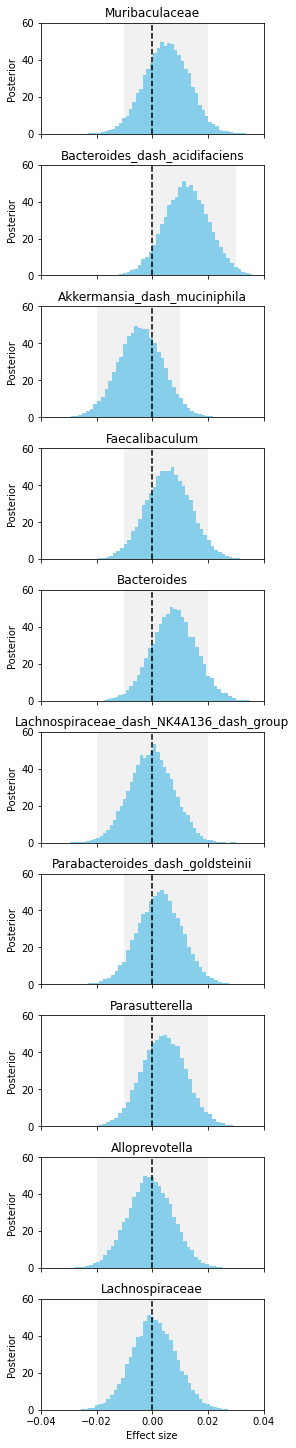

In [22]:
fig, ax = plt.subplots(figsize=(4, 20), nrows=10, ncols=1, constrained_layout=True, sharex=True, sharey=True)

# # first get the signal-to-noise ratio
# mean_dict = {}
# for k,c in enumerate(bacterial_taxons):
#     var = 'alpha__'+c
#     data = []
#     for i in np.arange(0,3):
#         data.extend(list(fit.posterior[var][i].values))
#     mean_dict[var] = np.mean(data)/np.std(data)

# mean_dict = {k: v for k, v in sorted(mean_dict.items(), key=lambda item: item[1])}
# k=0
#for var,v in mean_dict.items():
for k,c in enumerate(bacterial_taxons):
    var = 'alpha__'+c
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    
    
    ax[k].set_title(var.replace('alpha__','').replace('_slash_','/').replace('_space_',''))
    
    #ci95 = scipy.stats.bayes_mvs(data, alpha=0.95)[0][1]
    #ci95 = HDI_from_MCMC(data,0.95)
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    for (x0, x1) in hpd_mu:
        rect = patches.Rectangle((x0,0),x1-x0,60.0,linewidth=1,edgecolor=None,facecolor='lightgray',alpha=0.3)
        _ = ax[k].add_patch(rect)
    print(x0,x1)
    ax[k].hist(data, bins=50, density=True, color='skyblue')
    ax[k].plot([0,0],[0,60.0],'k--')
    #ax[k].plot([np.mean(data),np.mean(data)],[0,60.0],'r--')
    ax[k].set_xlim([-0.04,0.04])
    ax[k].set_ylim([0,60])
    
    if k==9:
        ax[k].set_xlabel('Effect size')
    ax[k].set_ylabel('Posterior')
    #k += 1
    
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bayesien_inference_growth_rate_chain3_nsample10000_warmup1000.svg", format="svg")

## inulin response

0.06 0.11
0.13 0.18
-0.03 0.02
0.02 0.06
0.0 0.05
-0.02 0.03
-0.02 0.03
0.01 0.05
-0.02 0.02
-0.02 0.03


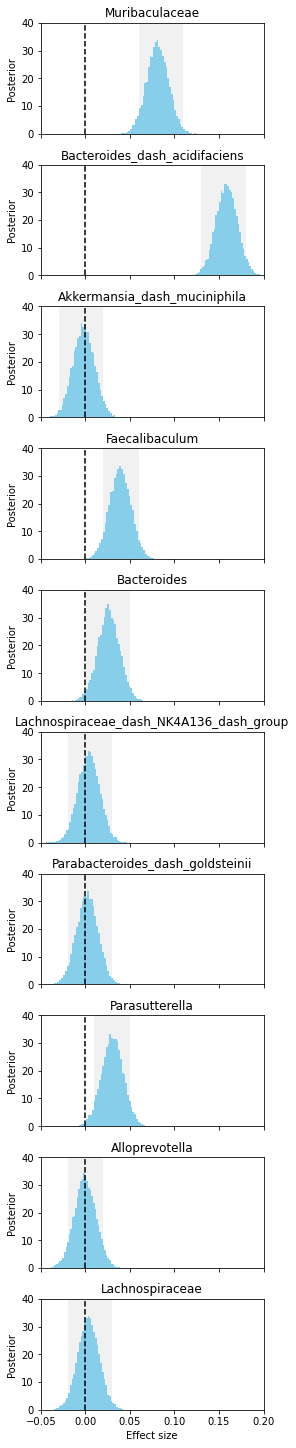

In [19]:
fig, ax = plt.subplots(figsize=(4, 20), nrows=10, ncols=1, constrained_layout=True, sharex=True, sharey=True)

# # first get the signal-to-noise ratio
# mean_dict = {}
# for k,c in enumerate(bacterial_taxons):
#     var = 'epsilon__'+c
#     data = []
#     for i in np.arange(0,3):
#         data.extend(list(fit.posterior[var][i].values))
#     mean_dict[var] = np.mean(data)/np.std(data)

# mean_dict = {k: v for k, v in sorted(mean_dict.items(), key=lambda item: item[1])}
# k=0
#for var,v in mean_dict.items():
for k,c in enumerate(bacterial_taxons):
    var = 'epsilon__'+c
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    ax[k].set_title(var.replace('epsilon__','').replace('_slash_','/').replace('_space_',''))
    
    #ci95 = scipy.stats.bayes_mvs(data, alpha=0.95)[0][1]
    #ci95 = HDI_from_MCMC(data,0.95)
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    for (x0, x1) in hpd_mu:
        rect = patches.Rectangle((x0,0),x1-x0,40.0,linewidth=1,edgecolor=None,facecolor='lightgray',alpha=0.3)
        _ = ax[k].add_patch(rect)
    print(x0,x1)
    ax[k].hist(data, bins=50, density=True, color='skyblue')
    ax[k].plot([0,0],[0,40.0],'k--')
    #ax[k].plot([np.mean(data),np.mean(data)],[0,40.0],'r--')
    ax[k].set_xlim([-0.05,0.20])
    ax[k].set_ylim([0,40])
    
    if k==9:
        ax[k].set_xlabel('Effect size')
    ax[k].set_ylabel('Posterior')
    #k += 1
    
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bayesien_inference_inulin_response_chain3_nsample10000_warmup1000.svg", format="svg")

## pairwise response

0
1
2
3
4
5
6
7
8
9


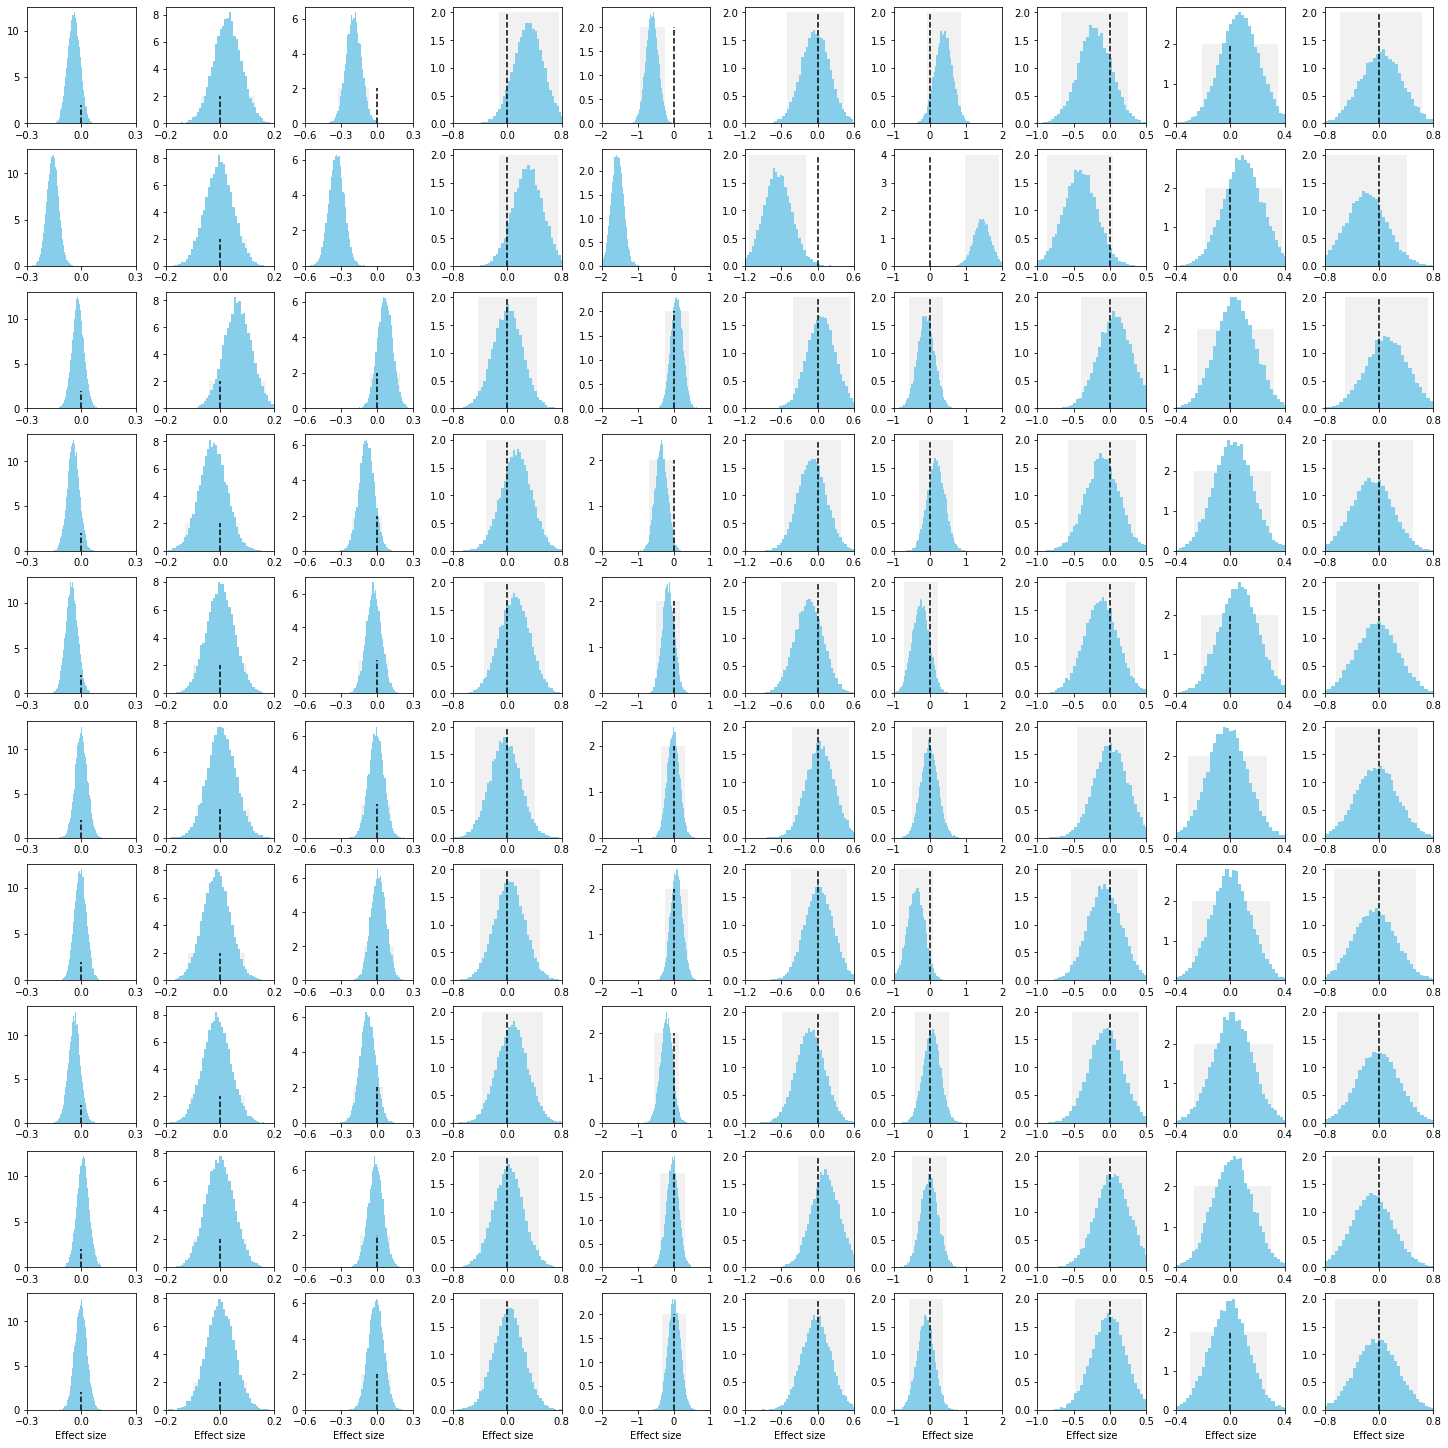

In [14]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=10, ncols=10, constrained_layout=True, sharex=False, sharey=False)

for k1,c1 in enumerate(bacterial_taxons):
    print(k1)
    for k2,c2 in enumerate(bacterial_taxons):
        var = 'beta__%s_%s'%(c1,c2)
        data = []
        for i in np.arange(0,3):
            data.extend(list(fit.posterior[var][i].values))

        max_data = np.max(data)
        upper_bound = np.ceil(max_data)
        if upper_bound %2 !=0:
            upper_bound += 1
            
        #ci95 = scipy.stats.bayes_mvs(data, alpha=0.95)[0][1]
        #ci95 = HDI_from_MCMC(data,0.95)
        hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
        for (x0, x1) in hpd_mu:
            rect = patches.Rectangle((x0,0),x1-x0,upper_bound,linewidth=1,edgecolor=None,facecolor='lightgray',alpha=0.3)
            _ = ax[k1,k2].add_patch(rect)
        ax[k1,k2].hist(data, bins=50, density=True, color='skyblue')
        ax[k1,k2].plot([0,0],[0,upper_bound],'k--')
        #ax[k1,k2].plot([np.mean(data),np.mean(data)],[0,20.0],'r--')
        #ax[k1,k2].set_ylim([0,15])

#         if k1==0:
#             ax[k1,k2].set_title(c2.replace('beta__','').replace('_slash_','/').replace('_space_',''))
        if k1==9:
            ax[k1,k2].set_xlabel('Effect size')
#         if k2==0:
#             ax[k1,k2].set_ylabel(c1.replace('beta__','').replace('_slash_','/').replace('_space_',''))
        

#         ax[k1,k2].set_ylim([0,upper_bound])
#         ax[k1,k2].set_yticks([0,upper_bound/2,upper_bound])
        
        if k2==0:
            ax[k1,k2].set_xlim([-0.3,0.3])
            ax[k1,k2].set_xticks([-0.3,0,0.3])
        if k2==1:
            ax[k1,k2].set_xlim([-0.2,0.2])
            ax[k1,k2].set_xticks([-0.2,0,0.2])
        if k2==2:
            ax[k1,k2].set_xlim([-0.6,0.3])
            ax[k1,k2].set_xticks([-0.6,-0.3,0,0.3])
        if k2==3:
            ax[k1,k2].set_xlim([-0.8,0.8])
            ax[k1,k2].set_xticks([-0.8,0,0.8])
        if k2==4:
            ax[k1,k2].set_xlim([-2,1])
            ax[k1,k2].set_xticks([-2,-1,0,1])
        if k2==5:
            ax[k1,k2].set_xlim([-1.2,0.6])
            ax[k1,k2].set_xticks([-1.2,-0.6,0,0.6])
        if k2==6:
            ax[k1,k2].set_xlim([-1,2])
            ax[k1,k2].set_xticks([-1,0,1,2])
        if k2==7:
            ax[k1,k2].set_xlim([-1,0.5])
            ax[k1,k2].set_xticks([-1,-0.5,0,0.5])
        if k2==8:
            ax[k1,k2].set_xlim([-0.4,0.4])
            ax[k1,k2].set_xticks([-0.4,0,0.4])
        if k2==9:
            ax[k1,k2].set_xlim([-0.8,0.8])
            ax[k1,k2].set_xticks([-0.8,0,0.8])
            
plt.show()

In [15]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bayesien_inference_pairwise_interaction_chain3_nsample10000_warmup1000.svg", format="svg")

# Plot data (standardized)

In [15]:
fit = az.from_cmdstan(["/Users/liaoc/Documents/cmdstan-2.24.1/results/mice_scfa_w_standardization/output_%d.csv"%(i) for i in np.arange(1,4)])

## growth rate

-0.63 0.63
-0.59 0.67
-0.66 0.59
-0.62 0.64
-0.61 0.64
-0.65 0.61
-0.64 0.62
-0.63 0.63
-0.64 0.61
-0.64 0.62


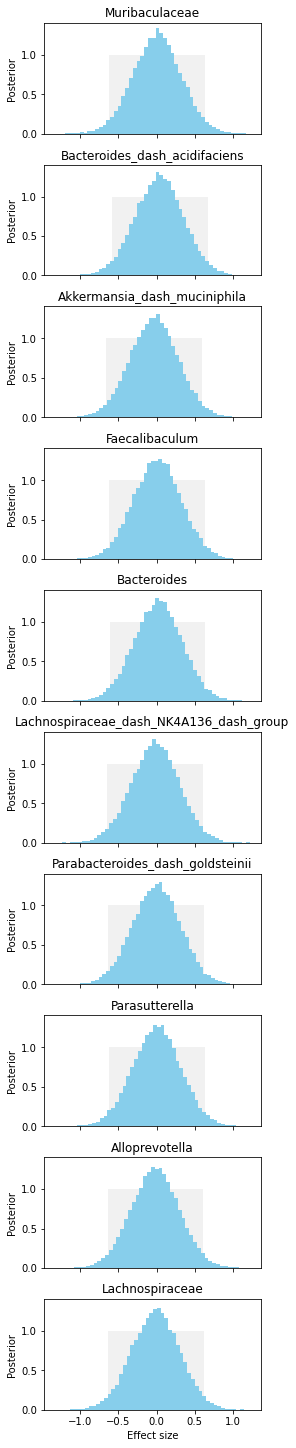

In [18]:
fig, ax = plt.subplots(figsize=(4, 20), nrows=10, ncols=1, constrained_layout=True, sharex=True, sharey=True)

# # first get the signal-to-noise ratio
# mean_dict = {}
# for k,c in enumerate(bacterial_taxons):
#     var = 'alpha__'+c
#     data = []
#     for i in np.arange(0,3):
#         data.extend(list(fit.posterior[var][i].values))
#     mean_dict[var] = np.mean(data)/np.std(data)

# mean_dict = {k: v for k, v in sorted(mean_dict.items(), key=lambda item: item[1])}
# k=0
#for var,v in mean_dict.items():
for k,c in enumerate(bacterial_taxons):
    var = 'alpha__'+c
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    
    
    ax[k].set_title(var.replace('alpha__','').replace('_slash_','/').replace('_space_',''))
    
    #ci95 = scipy.stats.bayes_mvs(data, alpha=0.95)[0][1]
    #ci95 = HDI_from_MCMC(data,0.95)
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    for (x0, x1) in hpd_mu:
        rect = patches.Rectangle((x0,0),x1-x0,1.0,linewidth=1,edgecolor=None,facecolor='lightgray',alpha=0.3)
        _ = ax[k].add_patch(rect)
    print(x0,x1)
    ax[k].hist(data, bins=50, density=True, color='skyblue')
    #ax[k].plot([0,0],[0,60.0],'k--')
    #ax[k].plot([np.mean(data),np.mean(data)],[0,60.0],'r--')
    #ax[k].set_xlim([-0.04,0.04])
    #ax[k].set_ylim([0,60])
    
    if k==9:
        ax[k].set_xlabel('Effect size')
    ax[k].set_ylabel('Posterior')
    #k += 1
    
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("bayesien_inference_growth_rate_chain3_nsample10000_warmup1000.svg", format="svg")

## inulin response

0.18 0.32
0.42 0.57
-0.08 0.07
0.05 0.2
0.01 0.15
-0.06 0.09
-0.07 0.08
0.02 0.17
-0.08 0.07
-0.06 0.08


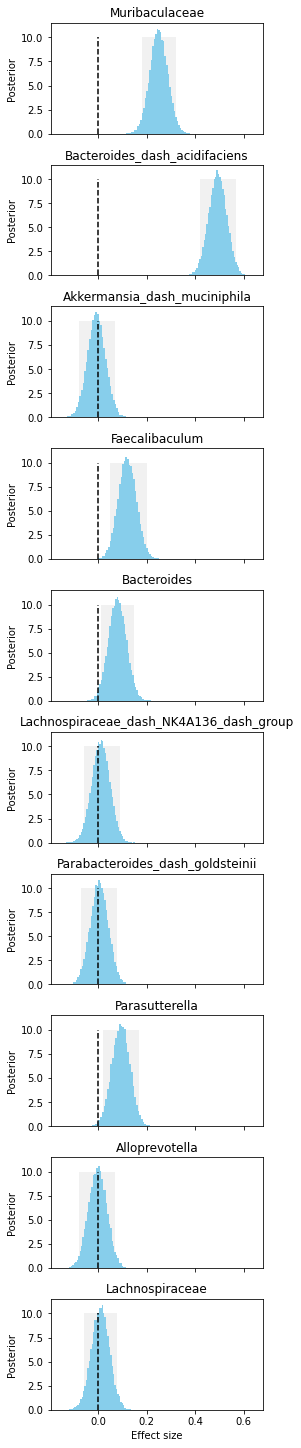

In [20]:
fig, ax = plt.subplots(figsize=(4, 20), nrows=10, ncols=1, constrained_layout=True, sharex=True, sharey=True)

# # first get the signal-to-noise ratio
# mean_dict = {}
# for k,c in enumerate(bacterial_taxons):
#     var = 'epsilon__'+c
#     data = []
#     for i in np.arange(0,3):
#         data.extend(list(fit.posterior[var][i].values))
#     mean_dict[var] = np.mean(data)/np.std(data)

# mean_dict = {k: v for k, v in sorted(mean_dict.items(), key=lambda item: item[1])}
# k=0
#for var,v in mean_dict.items():
for k,c in enumerate(bacterial_taxons):
    var = 'epsilon__'+c
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    ax[k].set_title(var.replace('epsilon__','').replace('_slash_','/').replace('_space_',''))
    
    #ci95 = scipy.stats.bayes_mvs(data, alpha=0.95)[0][1]
    #ci95 = HDI_from_MCMC(data,0.95)
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    for (x0, x1) in hpd_mu:
        rect = patches.Rectangle((x0,0),x1-x0,10.0,linewidth=1,edgecolor=None,facecolor='lightgray',alpha=0.3)
        _ = ax[k].add_patch(rect)
    print(x0,x1)
    ax[k].hist(data, bins=50, density=True, color='skyblue')
    ax[k].plot([0,0],[0,10.0],'k--')
    #ax[k].plot([np.mean(data),np.mean(data)],[0,40.0],'r--')
    #ax[k].set_xlim([-0.05,0.20])
    #ax[k].set_ylim([0,40])
    
    if k==9:
        ax[k].set_xlabel('Effect size')
    ax[k].set_ylabel('Posterior')
    #k += 1
    
#plt.rcParams['svg.fonttype'] = 'none'
#fig.savefig("bayesien_inference_inulin_response_chain3_nsample10000_warmup1000.svg", format="svg")

## pairwise interaction

0
1
2
3
4
5
6
7
8
9


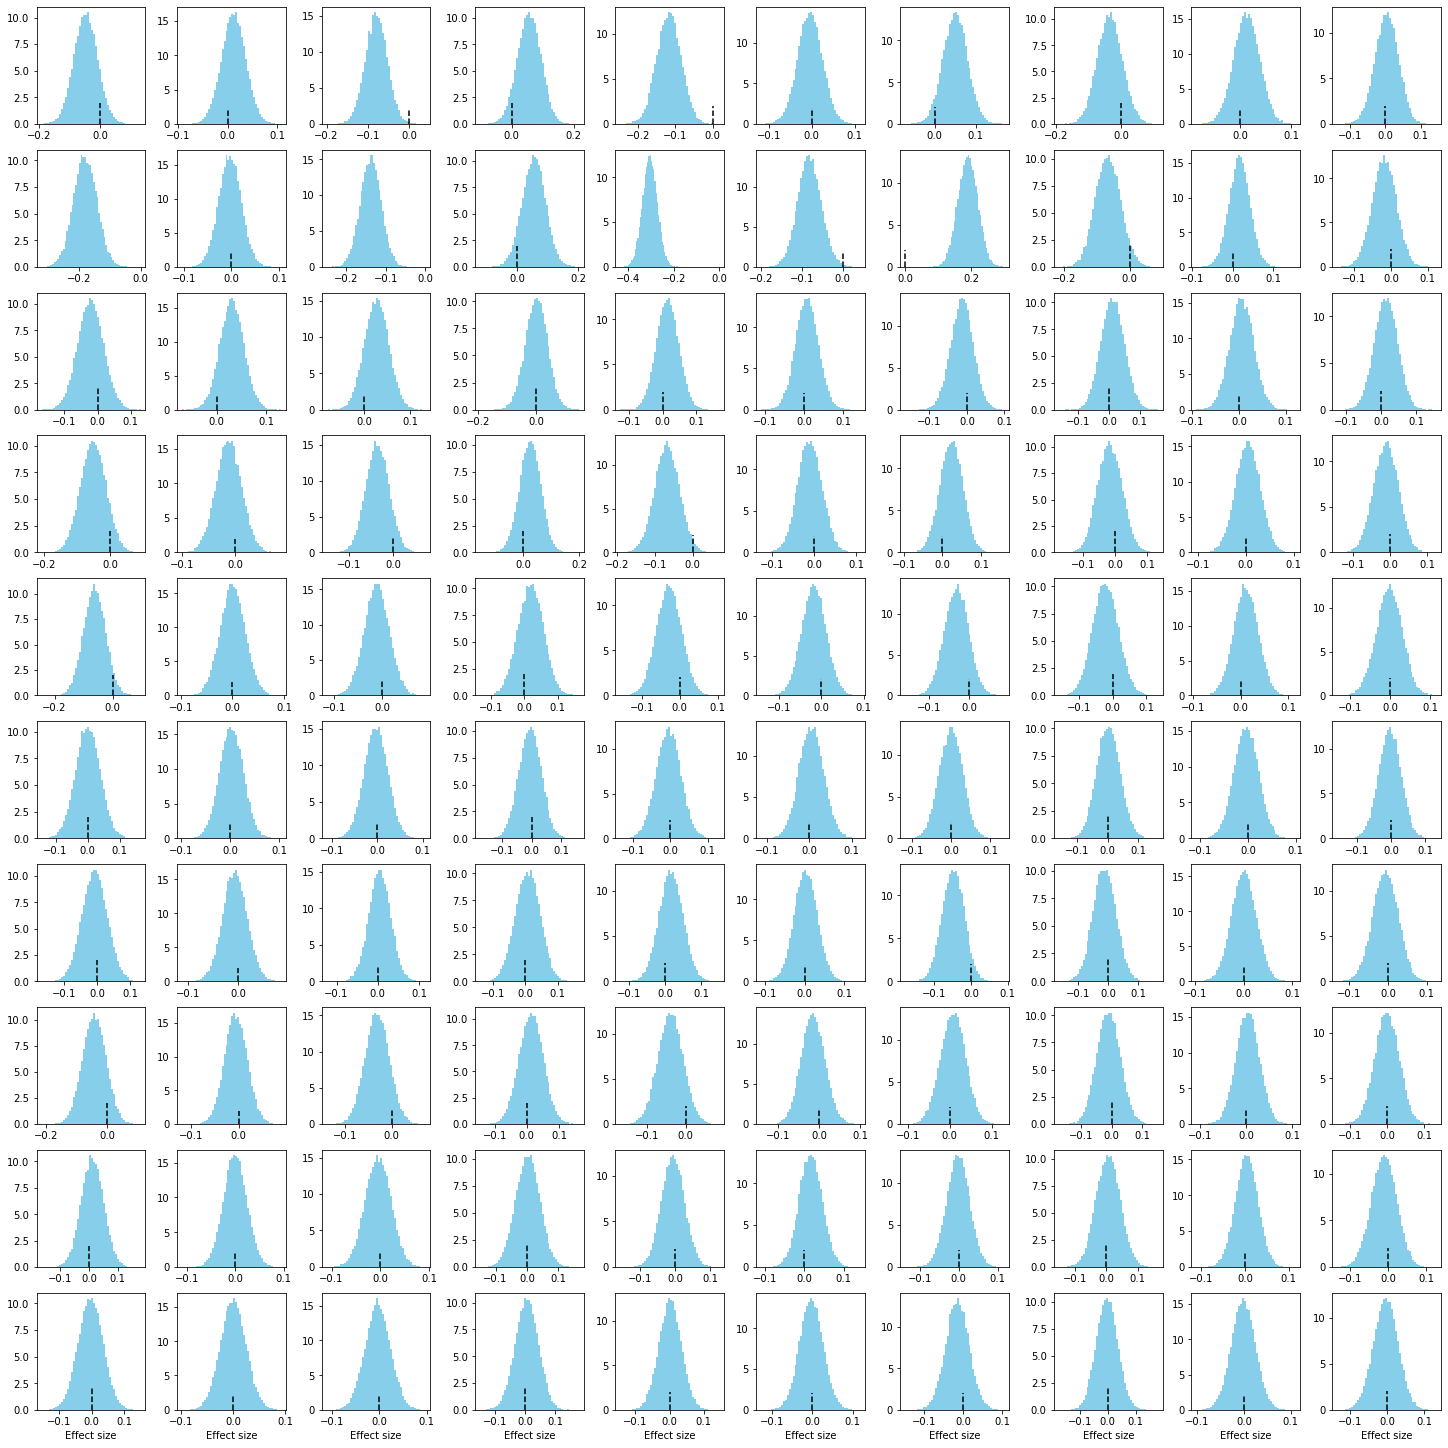

In [22]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=10, ncols=10, constrained_layout=True, sharex=False, sharey=False)

for k1,c1 in enumerate(bacterial_taxons):
    print(k1)
    for k2,c2 in enumerate(bacterial_taxons):
        var = 'beta__%s_%s'%(c1,c2)
        data = []
        for i in np.arange(0,3):
            data.extend(list(fit.posterior[var][i].values))

        max_data = np.max(data)
        upper_bound = np.ceil(max_data)
        if upper_bound %2 !=0:
            upper_bound += 1
            
        #ci95 = scipy.stats.bayes_mvs(data, alpha=0.95)[0][1]
        #ci95 = HDI_from_MCMC(data,0.95)
#         hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
#         for (x0, x1) in hpd_mu:
#             rect = patches.Rectangle((x0,0),x1-x0,upper_bound,linewidth=1,edgecolor=None,facecolor='lightgray',alpha=0.3)
#             _ = ax[k1,k2].add_patch(rect)
        ax[k1,k2].hist(data, bins=50, density=True, color='skyblue')
        ax[k1,k2].plot([0,0],[0,upper_bound],'k--')
        #ax[k1,k2].plot([np.mean(data),np.mean(data)],[0,20.0],'r--')
        #ax[k1,k2].set_ylim([0,15])

#         if k1==0:
#             ax[k1,k2].set_title(c2.replace('beta__','').replace('_slash_','/').replace('_space_',''))
        if k1==9:
            ax[k1,k2].set_xlabel('Effect size')
#         if k2==0:
#             ax[k1,k2].set_ylabel(c1.replace('beta__','').replace('_slash_','/').replace('_space_',''))
        

#         ax[k1,k2].set_ylim([0,upper_bound])
#         ax[k1,k2].set_yticks([0,upper_bound/2,upper_bound])
        
#         if k2==0:
#             ax[k1,k2].set_xlim([-0.3,0.3])
#             ax[k1,k2].set_xticks([-0.3,0,0.3])
#         if k2==1:
#             ax[k1,k2].set_xlim([-0.2,0.2])
#             ax[k1,k2].set_xticks([-0.2,0,0.2])
#         if k2==2:
#             ax[k1,k2].set_xlim([-0.6,0.3])
#             ax[k1,k2].set_xticks([-0.6,-0.3,0,0.3])
#         if k2==3:
#             ax[k1,k2].set_xlim([-0.8,0.8])
#             ax[k1,k2].set_xticks([-0.8,0,0.8])
#         if k2==4:
#             ax[k1,k2].set_xlim([-2,1])
#             ax[k1,k2].set_xticks([-2,-1,0,1])
#         if k2==5:
#             ax[k1,k2].set_xlim([-1.2,0.6])
#             ax[k1,k2].set_xticks([-1.2,-0.6,0,0.6])
#         if k2==6:
#             ax[k1,k2].set_xlim([-1,2])
#             ax[k1,k2].set_xticks([-1,0,1,2])
#         if k2==7:
#             ax[k1,k2].set_xlim([-1,0.5])
#             ax[k1,k2].set_xticks([-1,-0.5,0,0.5])
#         if k2==8:
#             ax[k1,k2].set_xlim([-0.4,0.4])
#             ax[k1,k2].set_xticks([-0.4,0,0.4])
#         if k2==9:
#             ax[k1,k2].set_xlim([-0.8,0.8])
#             ax[k1,k2].set_xticks([-0.8,0,0.8])
            
plt.show()